# PCMCI

**PCMCI (PC algorithm + Momentary Conditional Independence)** は、PC アルゴリズムを時系列用に拡張したもの。

- 高次元でもスケーラブル  
- 非線形検定にも対応  


## 目的

多変量時系列 $\{X_t^1, \ldots, X_t^N\}_{t=1}^T$ に対して、ラグ付き因果リンク $X_{t-\tau}^j \to X_t^i$ つまり時系列 DAG（Time Series Graph, TSG）の推定がゴール。


## アルゴリズム

PCMCI は次の2段階で構成される。

1. **PC₁ステップ（スクリーニング）**  
   → 候補親集合（potential parents）を削減する高速ステップ

2. **MCIステップ（Momentary Conditional Independence）**  
   → 有意な因果リンクのみを確定する厳密な検定


### PC₁ステップ：候補因果のスクリーニング

PC-stableアルゴリズムを時系列データに適用したものを$PC_1$アルゴリズムという。このアルゴリズムにより原因（親ノード）の候補を探索する。

対象変数 $X_{i,t}$ の候補親集合 $\{ X_{j,t-\tau} \mid j = 1 \ldots N,\; \tau = 1 \ldots \tau_{\max} \}$ に対して独立性検定/条件付き独立性検定を行い、独立が疑われる候補リンクを削除していく。

ここでは「真の親集合を取りこぼさない」ことを重視するため、偽陽性のエッジも含む。


### MCIステップ：因果リンクの最終判定

PC₁で残った候補リンクに対して、より厳密な条件付き独立性検定を行い、偽陽性のエッジを削除する。

リンク $X_{j,t-\tau} \to X_{i,t}$ を検定する

$$
X_{j,t-\tau} \;\perp\!\!\!\perp\; X_{i,t} \mid
\text{pa}(X_{i,t}) \setminus \{X_{j, t-\tau}\}, \text{pa}(X_{j, t-\tau})
$$

ここで

- $\text{pa}(X_{i,t})$, $\text{pa}(X_{j, t-\tau})$ はそれぞれ $X_{i,t}, X_{j, t-\tau}$ の親ノード
- $\text{pa}(X_{i,t}) \setminus \{X_{j,t-\tau}\}$ は $X_{j,t-\tau}$ を除いた最大タイムラグ$\tau$までの$X_{j,t}$の親ノード

p-value < α → 因果リンクあり（採択）

#### point

- 対象の親＋候補親の親まで条件付けすることで交絡を減らす  
- スクリーニング済なので次元が低く、有意性検定のパワーが高い  


## PCMCI の利点

**1. 高次元でも高速**

PC₁で候補が大幅に削減されるため、$O(N^2 \tau_{\max})$ 程度の計算量で実用的。

高次元になりがちな気候データを扱った研究などでも使われている。

**2. 強い自己相関・交絡への耐性**

MCI の条件集合設計により、偽陽性（Type I error）を抑制。

## 発展モデル

### PCMCI+（拡張版）
精度向上版で、追加機能：

- 同時刻（contemporaneous）因果も推定可能  
- v-structure の復元能力向上  
- 非線形依存の検出性能がさらに改善

## 実装

[Tigramite](https://github.com/jakobrunge/tigramite) パッケージで実行できる



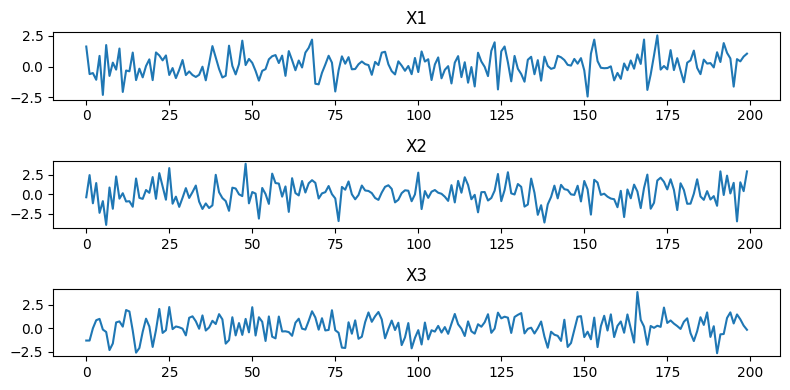

In [15]:
# 人工データの生成コード（出所：金本拓. (2024). 因果推論: 基礎から機械学習・時系列解析・因果探索を用いた意思決定のアプローチ. 株式会社 オーム社.）
import numpy as np
import matplotlib.pyplot as plt

# サンプルデータの生成
np.random.seed(1)

data_length = 200

# X1はノイズから生成
X1 = np.random.randn(data_length)

# X2はX1の1時点前のデータに依存し、1.0倍の値を持つ
X2 = np.empty(data_length)
X2[0] = np.random.randn()
for t in range(1, data_length):
    X2[t] = 1.0 * X1[t-1] + np.random.randn()

# X3はX2の2時点前のデータに依存し、0.2倍の値を持つ
X3 = np.empty(data_length)
X3[0] = X3[1] = np.random.randn()
for t in range(2, data_length):
    X3[t] = 0.2 * X2[t-2] + np.random.randn()

data = np.column_stack([X1, X2, X3])

# データの可視化
xiables = [X1, X2, X3]
titles = ['X1', 'X2', 'X3']

plt.figure(figsize=(8, 4))

for i, (x, title) in enumerate(zip(xiables, titles)):
    plt.subplot(3, 1, i+1)
    plt.plot(x)
    plt.title(title)

plt.tight_layout()
plt.show()

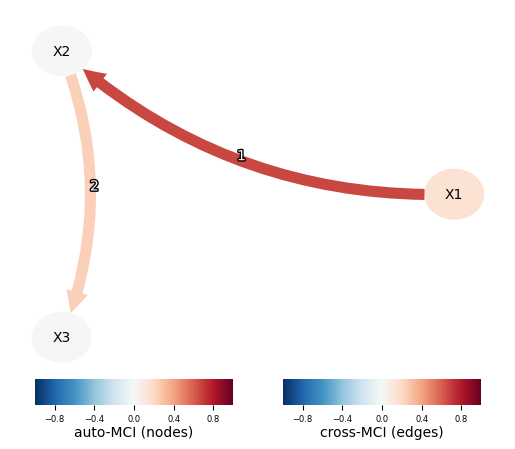

In [16]:
from tigramite.data_processing import DataFrame
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

dataframe = DataFrame(data)  # data: shape (T, N)

pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=ParCorr()
)

results = pcmci.run_pcmci(
    tau_min=0, # 最小のラグを0（同時期の因果関係）
    tau_max=5, # 最大のラグ
    pc_alpha=0.05 # 独立性検定の有意水準
)


# 結果をplot
from tigramite import plotting as tp
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=["X1", "X2", "X3"],
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)',
); plt.show()